In [2]:
import os
import re
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [3]:
image_folder = "../images_raw/jeremy/"
annotations_df = pd.read_csv('../annotations/combined_annotations.csv')

# Helper Functions

In [5]:
from PIL import Image
import albumentations as A
from collections import namedtuple
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [89]:
# Auxiliary Functions
def bbox_only_rotate(img, bboxes):
    bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}
    aug = A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params)
    anno = aug(image=img, bboxes=bboxes, labels=np.ones(len(bboxes)))
    new_bboxes = anno['bboxes']
    rotated_image = anno['image']
    
    # Extract the bboxed images from new_image and paste them in the original img
    # Create a copy of the original image to paste the rotated regions
    result_image = img.copy()

    # Iterate over the original and new bounding boxes
    for original_bbox, new_bbox in zip(bboxes, new_bboxes):
        # Extract coordinates
        x_min, y_min, x_max, y_max = [int(coord) for coord in original_bbox]
        new_x_min, new_y_min, new_x_max, new_y_max = [int(coord) for coord in new_bbox]

        # Extract the rotated region from the rotated image
        rotated_region = rotated_image[new_y_min:new_y_max, new_x_min:new_x_max]

        # Resize the rotated region to fit the original bbox size
        # original_width, original_height = x_max - x_min, y_max - y_min
        # resized_rotated_region = cv2.resize(rotated_region, (original_width, original_height))

        # Paste the resized rotated region onto the original image
        # result_image[y_min:y_max, x_min:x_max] = resized_rotated_region
        result_image[new_y_min:new_y_max, new_x_min:new_x_max] = rotated_region
    
    return result_image, new_bboxes

In [83]:
img_id = 'mwitt_2023_01_LGX042568.MP4_0014168.jpg'
img_id = 'mwitt_2022_01_LGX020075.MP4_0011799.jpg'

MAX_CROP = 150

chosen_img = read_img(img_id)
bboxes = read_bboxes(img_id, bbox_relative=True)
bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}

[ WARN:0@2620.910] global loadsave.cpp:248 findDecoder imread_('../images_raw/jeremy/mwitt_2022_01_LGX020075.MP4_0011799.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2620.912] global loadsave.cpp:248 findDecoder imread_('../images_raw/jeremy/mwitt_2022_01_LGX020075.MP4_0011799.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [84]:
# advanced_augmentation_list = [bbox_only_rotate]
advanced_augmentation_list = []

albumentation_list = [
    # Suggested by paper "Learning Data Augmentation Strategies for Object Detection"
    A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params),
    A.Compose([A.Equalize(p=1)], bbox_params=bbox_params),

    # A.Compose([A.MotionBlur(p=1, blur_limit=15)], bbox_params=bbox_params),
    # A.Compose([A.RandomBrightness(p=1)], bbox_params=bbox_params),
    A.Compose([A.RandomCrop(p=1, height=MAX_CROP, width=MAX_CROP)], bbox_params=bbox_params), 
    # A.Compose([A.RGBShift(r_shift_limit=(-60, 60), g_shift_limit=(-60, 60), b_shift_limit=(-60, 60), p=1)], bbox_params=bbox_params), 
    # A.Compose([A.VerticalFlip(p=1)], bbox_params=bbox_params), 
]

# Test Augmentation

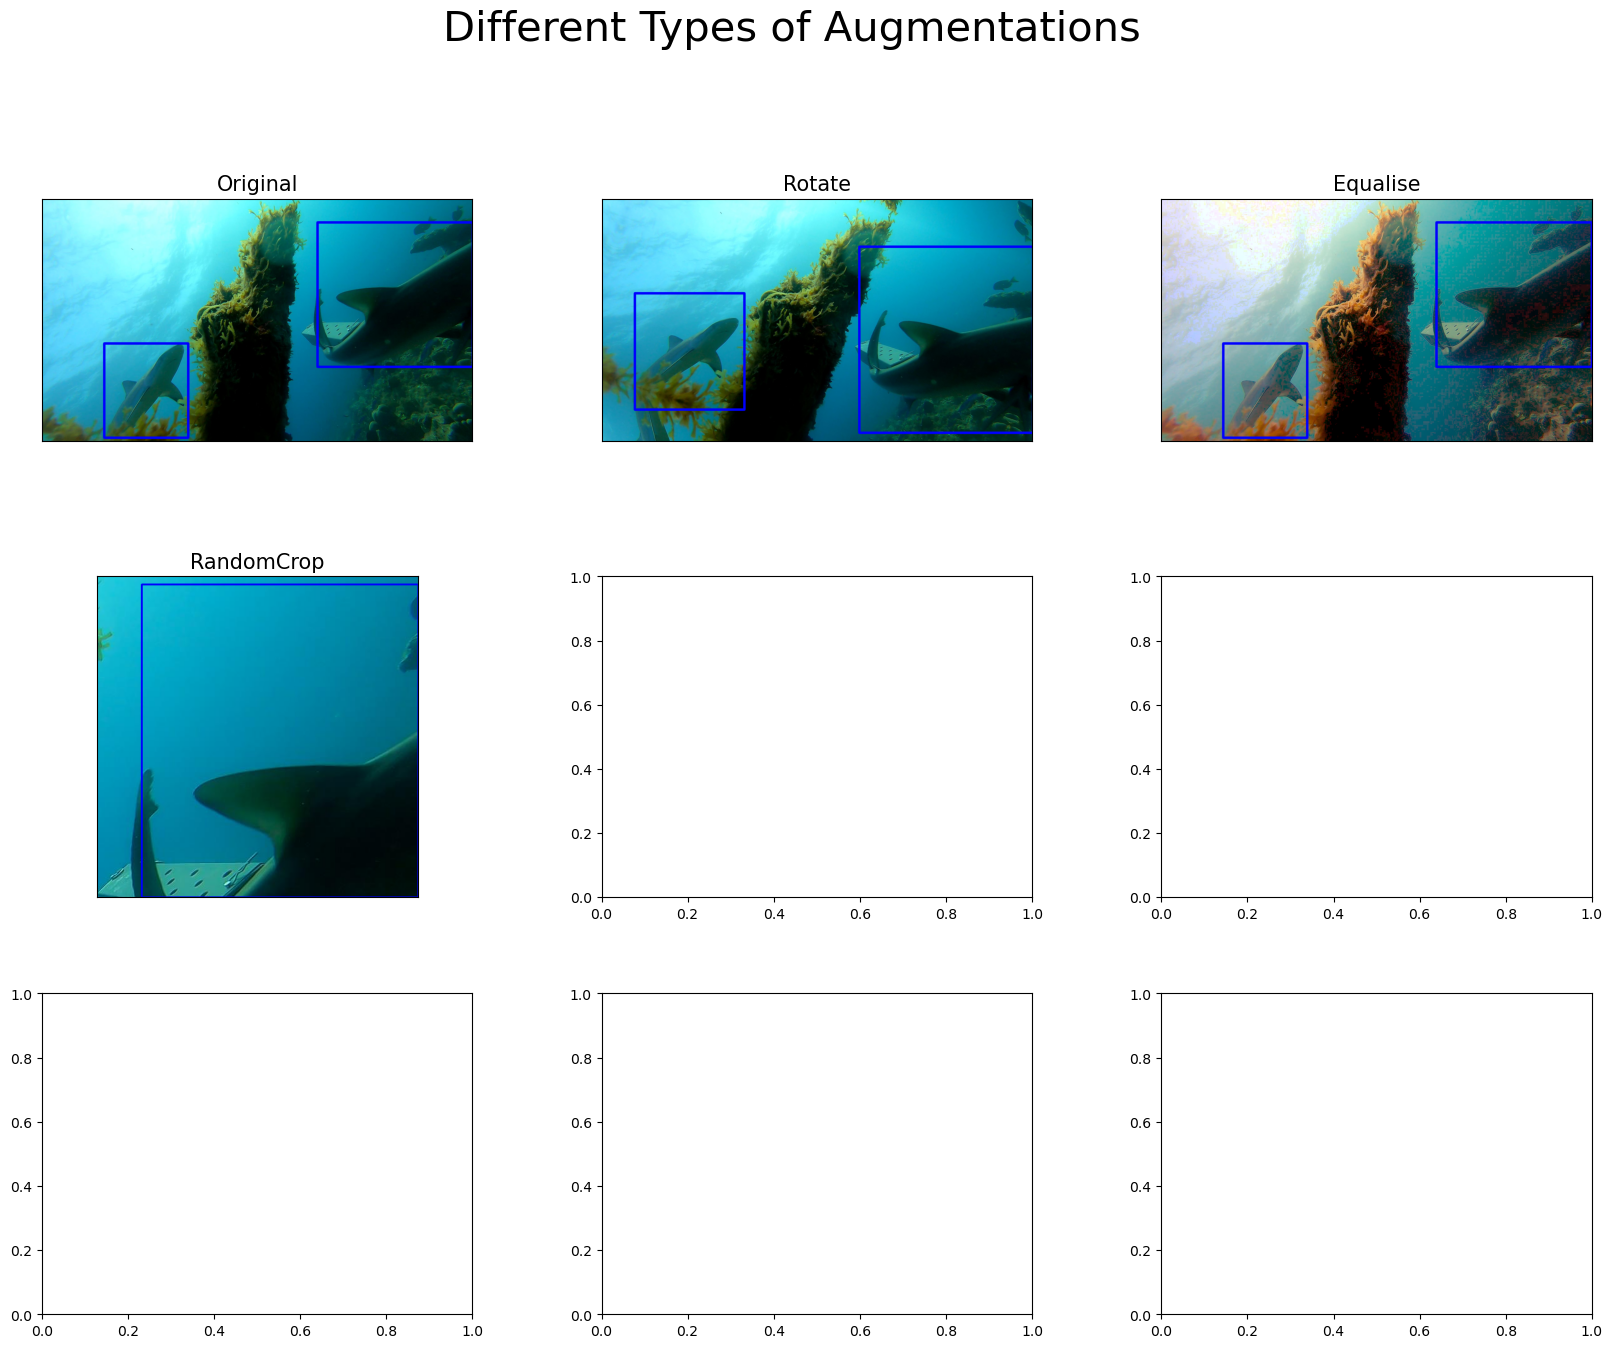

In [56]:
titles_list = ["Original", 
            #    "BboxRotate",
               "Rotate",
               "Equalise",
            #    "MotionBlur",
            #    "RandomBrightness", 
               "RandomCrop",
            #    "RGBShift", 
            #    "VerticalFlip"
               ]

img_matrix_list = [draw_rect(chosen_img, bboxes)]


for advanced_aug in advanced_augmentation_list:
    img, new_bboxes = advanced_aug(chosen_img, bboxes)
    img  = draw_rect(img, new_bboxes)
    img_matrix_list.append(img)


for i, aug_type in enumerate(albumentation_list):
    anno = aug_type(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)))
    img  = draw_rect(anno['image'], anno['bboxes'])
    img_matrix_list.append(img)

plot_multiple_img(img_matrix_list, 
                  titles_list, 
                  ncols = 3,
                  nrows=3, 
                  main_title="Different Types of Augmentations")

In [85]:
all_images = os.listdir(image_folder)
SOURCE = 'jeremy'

augmented_annotations = {
    'Filename': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': [],
    'Augmentation': [],
    'Family': [],
    'Genus': [],
    'Species': []
}


def update_annotations(new_img_id, new_bboxes, aug_name, labels):
    for i in range(len(new_bboxes)):
        family, genus, species = labels[i]
        augmented_annotations['Filename'].append(new_img_id)
        augmented_annotations['xmin'].append(new_bboxes[i][0])
        augmented_annotations['ymin'].append(new_bboxes[i][1])
        augmented_annotations['xmax'].append(new_bboxes[i][2])
        augmented_annotations['ymax'].append(new_bboxes[i][3])
        augmented_annotations['Augmentation'].append(aug_name)
        augmented_annotations['Family'].append(family)
        augmented_annotations['Genus'].append(genus)
        augmented_annotations['Species'].append(species)
        augmented_annotations['Source'].append(SOURCE)


# For all images, apply the augmentation and save the image in the images/augmented folder
# also, update the annotations file with the new image name and bounding boxes and the augmentation type
for img_id in all_images:
  if img_id.endswith('.jpg'):
    chosen_img = read_img(img_id)
    bboxes = read_bboxes(img_id, bbox_relative=True)
    labels = read_annotations(img_id)
    
    bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}
    img_filename = '.'.join(img_id.split('.')[:-1])

    for i, advanced_aug in enumerate(advanced_augmentation_list):
        img, augmented_bboxes = advanced_aug(chosen_img, bboxes)

        # Save new image
        aug_name = titles_list[i+1]
        new_img_id = img_filename + '_' + aug_name + '.jpg'
        cv2.imwrite(f'../images/augmented/{new_img_id}', img)

          # Update annotations
        update_annotations(new_img_id, augmented_bboxes, aug_name, labels)

    for i, aug_type in enumerate(albumentation_list):
        anno = aug_type(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)))
        img  = anno['image']

        # Save new image
        aug_name = titles_list[i+1+len(advanced_augmentation_list)]
        new_img_id = img_filename + '_' + aug_name + '.jpg'
        img_path = f'../images_raw/augmented_sl/{new_img_id}'
        cv2.imwrite(img_path, img)

        # New BBoxes
        new_bboxes = anno['bboxes']
        if len(new_bboxes) == 0:
            continue
        
        # Turn array of tuples into array of arrays
        new_bboxes = np.array([list(bbox) for bbox in new_bboxes])
        new_bboxes = normalise_bbox(new_bboxes, None, img)

        # Update annotations
        update_annotations(new_img_id, new_bboxes, aug_name, labels)

In [111]:
# annotations_df = pd.read_csv('../annotations/mwitt_annotations.csv')
# augmented_annotations_df = pd.concat([annotations_df, pd.DataFrame(augmented_annotations)], ignore_index=True)

In [86]:
augmented_annotations_df = pd.DataFrame(augmented_annotations)

In [89]:
augmented_annotations_df.head()

,Filename,xmin,ymin,xmax,ymax,Augmentation,Family,Genus,Species,Source
0,07-05-18_SqSq_BigugliaCorse_LapinksiGiovos2019...,0.000000,0.000000,1.000000,0.962181,Rotate,shark,NaN,NaN,SL
1,07-05-18_SqSq_BigugliaCorse_LapinksiGiovos2019...,0.090909,0.048701,0.804545,0.941558,Equalise,shark,NaN,NaN,SL
2,07-05-18_SqSq_BigugliaCorse_LapinksiGiovos2019...,0.000000,0.000000,0.900000,1.000000,RandomCrop,shark,NaN,NaN,SL
3,08-12-18_Blue_CastrillonSpain_lnees_Rotate.jpg,0.158319,0.000000,0.914803,0.915898,Rotate,shark,NaN,NaN,SL
4,08-12-18_Blue_CastrillonSpain_lnees_Equalise.jpg,0.189024,0.238889,0.896341,0.727778,Equalise,shark,NaN,NaN,SL


In [90]:
augmented_annotations_df.to_csv('../annotations/augmented_annotations_sl.csv', index=False)

# CutOut
Manually implemented because I want the cutout to be randomly centred inside the 
bounding box, and albumentation doesn't have it. Note that it doesn't change the bounding box

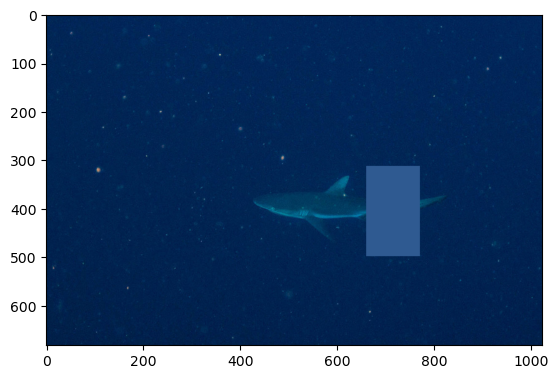

In [122]:
import cv2
import numpy as np
import random

def apply_custom_cutout(image_id, fill_color=(130, 160, 160)):
    """
    Applies a custom cutout augmentation within specified bounding boxes.

    :param image: A numpy array representing the RGB image.
    :param bboxes: A list of bounding boxes in relative coordinates (xmin, ymin, xmax, ymax).
    :param max_height: Maximum height of the cutout.
    :param max_width: Maximum width of the cutout.
    :param fill_color: RGB color for the cutout area.
    :return: Augmented image.
    """
    image = read_img(image_id, image_folder)
    bboxes = read_bboxes(image_id, annotations_df, image_folder, bbox_relative=True) # Bounding boxes in absolute coordinates
    h, w = image.shape[:2]

    bbox_index = np.random.randint(0, len(bboxes))
    bbox = bboxes[bbox_index]

    # Convert relative bbox to absolute coordinates
    xmin, ymin, xmax, ymax = [int(bbox[i]) for i in range(4)]

    # Random center point within the bbox
    center_x = np.random.randint(xmin, xmax)
    center_y = np.random.randint(ymin, ymax)

    # Max width and max heigth is equal to max(1.5x bbox width, image_width) and max(1.5x bbox height, image_height)
    max_height = min(int(1.5 * (ymax - ymin)), h)
    max_width = min(int(max_height * 0.5), w)

    min_height = min(int((ymax - ymin)), h)
    min_height = min(min_height, max_height - 1)
    min_width = min(int(0.3 * (xmax - xmin)), max_width - 1)


    # Random height and width of the cutout
    cutout_width = np.random.randint(min_width, max_width)
    cutout_height = np.random.randint(min_height, max_height)

    # Calculating the top left corner of the cutout
    x1 = max(center_x - cutout_width // 2, 0)
    y1 = max(center_y - cutout_height // 2, 0)

    # Ensure cutout does not exceed bbox boundaries
    x2 = min(x1 + cutout_width, w)
    y2 = min(y1 + cutout_height, h)

    # Apply cutout
    image[y1:y2, x1:x2] = fill_color

    return image

# Example usage
image_id = 'sl_1111326.jpg'

# Apply the custom cutout
augmented_image = apply_custom_cutout(image_id, fill_color=(145, 90, 47))
augmented_image = draw_bbox(None, image_folder, annotations_df, img=augmented_image)


# # Display or save the result
# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [123]:
image_folder = '../mvd/train/images/'
output_folder = '../images_raw/augmented_cutout/'
annotation_output = '../annotations/cutout.csv'

# Randomly sample 500 images from the training set, apply the custom cutout and save the results in the output_folder
# Also, copy the respective annotation from the annotation_df and create a new dataframe with the new annotations
import random
import shutil

# Randomly sample 500 images from the training set
all_images = os.listdir(image_folder)
random.shuffle(all_images)

# Create a new dataframe with the new annotations by just getting the rows with Filename = image_id sampled
cutout_annotations = annotations_df[annotations_df['Filename'].isin(all_images[:500])].copy()

for i, img_id in enumerate(all_images[:500]):
  if img_id.endswith('.jpg') and img_id in cutout_annotations['Filename'].values:
    # Apply the custom cutout
    augmented_image = apply_custom_cutout(img_id, fill_color=(145, 90, 47))

    # Save the augmented image
    cv2.imwrite(output_folder + img_id, augmented_image)

    # Update the annotation file Filename by just adding _cutout to the Filename
    cutout_annotations.loc[cutout_annotations['Filename'] == img_id, 'Filename'] = img_id[:-4] + '_cutout.jpg'

    if i % 100 == 0:
        print(f'Processed {i} images')

# Save the new annotations
cutout_annotations.to_csv(annotation_output, index=False)


Processed 0 images
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images


In [125]:
cutout_annotations.head()

,Filename,Family,Genus,Species,ymin,xmin,xmax,ymax,Augmentation,Source
4,mwitt_2021_01_LGX020009.MP4_0019403_cutout.jpg,Carcharhinidae,Carcharhinus,perezi,0.551852,0.772917,0.903646,0.695370,NaN,mwitt
9,mwitt_2021_01_LGX040010.MP4_0014300_cutout.jpg,Carcharhinidae,Carcharhinus,perezi,0.404630,0.056250,0.208854,0.469444,NaN,mwitt
20,mwitt_2021_01_LGX040009.MP4_0003595_cutout.jpg,Carcharhinidae,Carcharhinus,perezi,0.465741,0.017708,0.189062,0.536111,NaN,mwitt
45,mwitt_2022_01_LGX050043.MP4_0012986_cutout.jpg,Carcharhinidae,Negaprion,brevirostris,0.318519,0.007812,0.282813,0.450000,NaN,mwitt
52,mwitt_2022_01_LGX040071.MP4_0018461_cutout.jpg,Carcharhinidae,Carcharhinus,perezi,0.390981,0.423870,0.494359,0.496241,NaN,mwitt


In [126]:
# Update the cutout annotations file to have in the Augmentation column, the value '{Augmentation (if not NaN)}, Cutout'
cutout_annotations = pd.read_csv(annotation_output)
cutout_annotations['Augmentation'] = cutout_annotations['Augmentation'].fillna('') + ' Cutout'
cutout_annotations.to_csv(annotation_output, index=False)

In [127]:
all_annotations = pd.read_csv('../annotations/combined_annotations.csv')
cutout_annotations = pd.read_csv('../annotations/cutout.csv')

all_annotations = pd.concat([all_annotations, cutout_annotations], ignore_index=True)
all_annotations.to_csv('../annotations/combined_annotations_1.csv', index=False)